# PeDistance Linear Regression

### Initial settings

#### Dependencies

In [1]:
# YOLOv5 install dependencies
%pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 

Note: you may need to restart the kernel to use updated packages.


In [2]:
#imutils
%pip install imutils

Note: you may need to restart the kernel to use updated packages.


#### Imports and Utilities

In [2]:
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import base64
from PIL import Image
import cv2
from pathlib import Path
from __future__ import print_function
import imutils
from imutils.object_detection import non_max_suppression
from imutils import paths
import argparse
import matplotlib.image as mpimg
import io

%matplotlib notebook

In [3]:
# Used as file name where saving model state
model_file_name="reg_state.pth"
image_width = 640
image_height = 360

# Get device based on available hardware
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# Convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.tensor(df.to_numpy()).float().to(device)

### Import Dataset

In [48]:
# Filtered fields read from dataset csv file made up with yolo 
fields = [
    'Distance',
    'Xmin', 
    'Ymin',
    'Xmax', 
    'Ymax',
    'B64File'
]

df = pd.read_csv (r'./yoloDataset.csv', usecols=fields)
print(df.shape)
print(df)

(4382, 6)
       Distance      Xmin     Ymin      Xmax     Ymax  \
0     12.643298  1371.000  440.625  1428.000  601.125   
1      8.608026  1465.500  634.500  1539.000  885.000   
2     13.141609   353.625  406.125   414.375  571.875   
3      6.765636   572.625  564.000   681.375  867.750   
4      9.886651   573.750  507.750   654.000  708.000   
...         ...       ...      ...       ...      ...   
4377  10.101000  1153.500  468.000  1212.000  673.500   
4378  11.152000  1330.500  706.500  1402.500  871.500   
4379  10.943000  1303.500  510.000  1369.500  700.500   
4380  11.462000   434.625  515.250   482.625  685.500   
4381  11.298000   482.625  418.500   536.625  605.250   

                                                B64File  
0     /9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAgGBgcGBQgHBw...  
1     /9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAgGBgcGBQgHBw...  
2     /9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAgGBgcGBQgHBw...  
3     /9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAgGBgcGBQgHBw...  
4     /9j/4AAQS

In [20]:
# Filtered fields read from dataset csv file made up with PeDistance Mod
fields = [
    'Distance',
    'PedBottomLeftX', 
    'PedBottomLeftY',
    'PedTopRightX', 
    'PedTopRightY',
    'B64File'
]

df = pd.read_csv (r'./Dataset.csv', usecols=fields)
print(df.shape)
print(df)

(10022, 6)
        Distance  PedBottomLeftX  PedBottomLeftY  PedTopRightX  PedTopRightY  \
0      12.643298            1353             612          1449           429   
1       8.608026            1432             913          1576           622   
2      13.141609             341             579           436           396   
3       9.342564            1210             747          1282           505   
4       9.960917            1144             712          1207           490   
...          ...             ...             ...           ...           ...   
10017  11.152000            1315             905          1420           693   
10018  10.943000            1290             719          1393           507   
10019  10.585000            1191             714          1281           507   
10020  11.462000             415             713           501           502   
10021  11.298000             471             613           541           413   

                            

### Dataset Pre Analysis

In [21]:
pre_an_df = df.drop('B64File', axis=1)
pre_an_df = pre_an_df.round(0).astype(int).groupby('Distance').size().reset_index(name='Counts')
print(pre_an_df.to_string(index=False))

 Distance  Counts
        5     244
        6     442
        7     473
        8     435
        9     440
       10     412
       11     461
       12     395
       13     420
       14     386
       15     402
       16     416
       17     377
       18     377
       19     385
       20     376
       21     361
       22     338
       23     334
       24     304
       25     343
       26     315
       27     293
       28     294
       29     254
       30     161
       31     112
       32      66
       33      33
       34      14
       35       6
       36       5
       37       1
       41       1
       43       2
       44       3
       45       2
       46       7
       47       9
       48      17
       49      26
       50      27
       51      44
       52      39
       53      35
       54      42
       55      32
       56      31
       57      10
       58       8
       59       5
       60       4
       61       1
       62       2


<IPython.core.display.Javascript object>


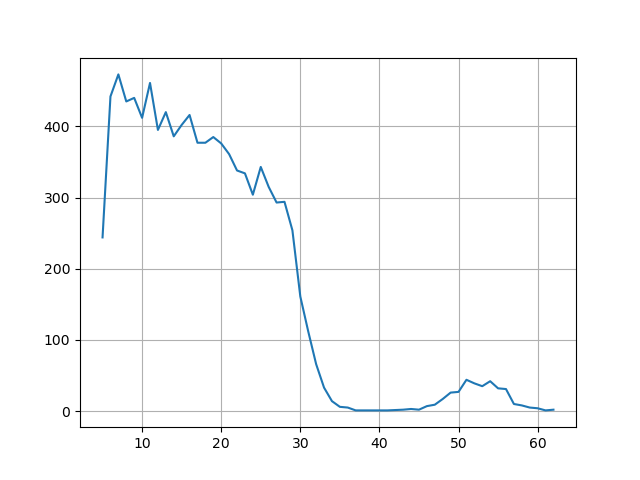

In [22]:
# plotting pre analysis
plt.plot(pre_an_df.Distance, pre_an_df.Counts)
plt.grid()
plt.show()

### Normalize input feature 

In [36]:
def get_image_resolution(b64string):
    image = base64.b64decode(b64string)
    image = io.BytesIO(image)
    image = mpimg.imread(image, format='JPG')
    return image.shape
    
testone = df['B64File'][0]    
get_image_resolution(testone)

(1080, 1920, 3)

### Splitting dataset


In [37]:
# sklearn function to split pandas dataframe into train and test set
train, test = train_test_split(df, test_size = 0.3)
train = shuffle(train)

In [38]:
# parsing dataframes to pytorch tensor
Y_training = df_to_tensor(train.Distance)
Y_testing = df_to_tensor(test.Distance)

print(Y_training.shape)
print(Y_testing.shape)

torch.Size([7015])
torch.Size([3007])


#### Getting width  height from raw 2D screen points

In [39]:
# To run when PeDistance dataset is loaded
def get_resized_box_dim(el, image_width, image_height):
    width = abs(el.PedTopRightX - el.PedBottomLeftX)
    height = abs(el.PedBottomLeftY - el.PedTopRightY)
    res = get_image_resolution(el.B64File)
    width = int((width * image_width) / res[1])
    height = int((height * image_height) / res[0])
    return width, height, width**2, height**2, width**3, height**3, width**4, height**4

In [33]:
# To run when yolo dataset is loaded
def get_resized_box_dim(el, image_width, image_height):
    width = abs(el.Xmax - el.Xmin)
    height = abs(el.Ymax - el.Ymin)
    res = get_image_resolution(el.B64File)
    width = int((width * image_width) / res[1])
    height = int((height * image_height) / res[0])
    return width, height, width**2, height**2, width**3, height**3

In [ ]:
# building dataset features
X_training = df_to_tensor(train.apply(lambda el :  pd.Series(get_resized_box_dim(el, image_width, image_height), index=['width', 'height', 'width**2', 'height**2', 'width**3', 'height**3', 'width**4', 'height**4']), axis=1))
X_testing = df_to_tensor(test.apply(lambda el :  pd.Series(get_resized_box_dim(el, image_width, image_height), index=['width', 'height', 'width**2', 'height**2', 'width**3', 'height**3', 'width**4', 'height**4']), axis=1))

print(X_training.shape)
print(X_testing.shape)

### Linear Regression Module

In [33]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        super(LinearRegressor, self).__init__()
        self.criterion = nn.MSELoss()
        self.linear = nn.Linear(in_size,out_size)       
        
    # used to train linear regressor
    def fit(self, X_training, Y_training, X_testing, Y_testing, lr= 0.001, epochs=40000, momentum=0.0, reset_parameters= False):
        self.reset_parameters(reset_parameters)
        
        self.mean = X_training.mean(0)
        self.stds = X_training.std(0)
        X_training_norm = self._data_normalization(X_training)
        X_testing_norm = self._data_normalization(X_testing)
                
        self.optimizer = torch.optim.SGD(reg.parameters(), lr=lr, momentum=momentum)
        self.writer = SummaryWriter('logs/linear_regressor_lr' + str(lr) + '_momentum' + str(momentum) + '_epochs' + str(epochs) + '_mean' + str(self.mean[0].cpu().numpy()))
        
        self._training(X_training_norm, Y_training, X_testing_norm, Y_testing, lr, epochs, momentum)
       
    def _training(self, X_training_norm, Y_training, X_testing_norm, Y_testing, l, epochs, momentum):
       
        for e in range(epochs):   
            reg.train()
            preds_train = self.forward(X_training_norm)
            l = self.criterion(preds_train.view(-1),Y_training)

            self.writer.add_scalar('loss/train', l.item(), global_step=e)

            l.backward()

            self.optimizer.step()    
            self.optimizer.zero_grad()
            
            reg.eval()
            with torch.set_grad_enabled(False):
                preds_test = self.forward(X_testing_norm)
                l = self.criterion(preds_test.view(-1),Y_testing)
                self.writer.add_scalar('loss/test', l.item(), global_step=e)    
        
    # used to get prediction based on trained linear regressor
    def predict(self, X):  
        X_norm = self._data_normalization(X)
        return self.linear(X_norm)
       
    # used to get final score tensor and predicted tensor based on train or test features and labels
    def score(self, X, Y):
        Y_preds = self.predict(X)
        l = self.criterion(Y_preds.view(-1),Y)
        return l, Y_preds
    
    # used to reset parameters before training
    def reset_parameters(self, reset_parameters= False):
        if reset_parameters:
            for layer in self.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
    
    # used to load parameters and model state to make predictions or continue training
    def load_state(self, path):
        if Path(path).exists():
            checkpoint = torch.load(path, map_location=get_device())
            self.mean = checkpoint["mean"]
            self.stds = checkpoint["stds"]
            self.load_state_dict(checkpoint["model_state_dict"])
    
    # used to save trained model state
    def save_state(self, path):
         torch.save({
            'mean': self.mean,
            'stds': self.stds,
            'model_state_dict': self.state_dict(),
            }, path)
    
    # used to normalize data (zero mean normalization)
    def _data_normalization(self, data):
        return (data-self.mean)/self.stds        
    
    def forward(self,x):
        result = self.linear(x)
        return result    

### Modular Linear Regression

In [34]:
# getting model object
reg = LinearRegressor(8,1).to(get_device())

In [76]:
# OPTIONAL: load saved state by running this cell (you need to train the model before loading states)
reg.load_state(model_file_name)

In [35]:
# OPTIONAL: train the model and save the current trained state by running this cell
reg.fit(X_training, Y_training, X_testing, Y_testing, reset_parameters=True, epochs=200000, momentum=0.9, lr=0.001)
reg.save_state(model_file_name)

In [1]:
# Keep track of your learning using tensorboard
%reload_ext tensorboard
%tensorboard --logdir ./logs --host localhost

Reusing TensorBoard on port 6006 (pid 13636), started 3 days, 18:58:25 ago. (Use '!kill 13636' to kill it.)

### Regressor REC Curve

In [57]:
# Defining rec curve function
def rec_curve(predictions, gt):
    assert predictions.shape == gt.shape
    errors = np.abs(np.array((predictions.detach()-gt)))
    tolerances = sorted(np.unique(errors))
    correct= [] 
    for t in tolerances:
        correct.append((errors<=t).mean()) 
    AUC = np.trapz(correct, tolerances) 
    tot_area = np.max(tolerances)*1 
    AOC = tot_area - AUC
    return tolerances, correct, AOC

<IPython.core.display.Javascript object>


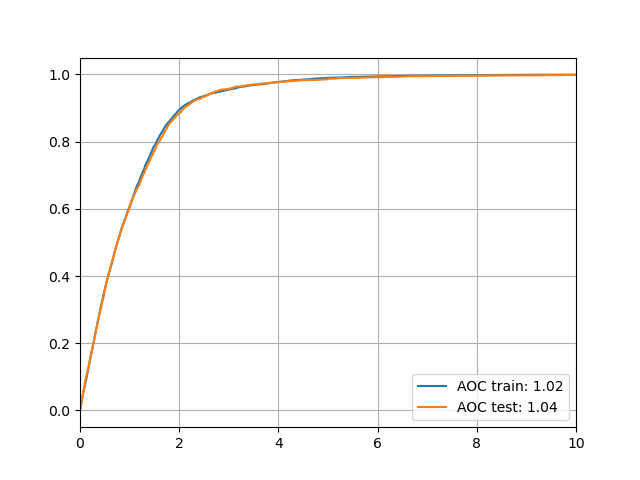

In [61]:
# Plotting train and test REC curve, respectively with their AOC
preds_training = reg.predict(X_training)
linear_regressor_rec = rec_curve(preds_training.view(-1).cpu(),Y_training.cpu())
plt.plot(linear_regressor_rec[0], linear_regressor_rec[1])

preds_testing = reg.predict(X_testing)
linear_regressor_rec_test = rec_curve(preds_testing.view(-1).cpu(),Y_testing.cpu())
plt.plot(linear_regressor_rec_test[0], linear_regressor_rec_test[1])
plt.legend(['AOC train: %0.2f'%linear_regressor_rec[2], 'AOC test: %0.2f'%linear_regressor_rec_test[2]])

plt.xlim(0, 10)
plt.grid()
plt.show()

## YOLOv5

In [63]:
# Defining yolov5 pretrained model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\danil/.cache\torch\hub\ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 
YOLOv5  2021-6-21 torch 1.8.0 CUDA:0 (NVIDIA GeForce RTX 2060, 6144.0MB)



### Get boxes from image

In [85]:
# Getting image from local, change image_name_path to select your image
image_name_path='Test8.jpg'
img = Image.open(image_name_path).convert("RGB").resize((image_width, image_height))

# Inference
results = model(img)

results.pandas().xyxy[0]  # img1 predictions (pandas)

,xmin,ymin,xmax,ymax,confidence,class,name
0,456.5,146.75,476.0,201.25,0.74707,0,person


### Get predictions

In [88]:
# Filtering person recognitions
box_img = np.asarray(img)
person_box = []
person_box_pol = []
obj_recognized = results.xyxy[0].cpu().numpy()
paddingH = 0
paddingW = 0

for obj in obj_recognized:
    if obj[5] == 0:
        width = abs(obj[2] - obj[0]) 
        heigth = abs(obj[3] - obj[1])
        person_box.append([obj[0]  - paddingW , obj[1] - paddingH, obj[2]  + paddingW, obj[3]  + paddingH]) 
        width = abs((obj[2] + paddingW) - (obj[0] - paddingW)) 
        heigth = abs((obj[3] + paddingH) - (obj[1] - paddingH))
        person_box_pol.append([width, heigth, width**2, heigth**2, width**3, heigth**3, width**4, heigth**4])

y_pred = reg.predict(torch.tensor(np.array(person_box_pol, dtype=np.float32)).to(get_device())).squeeze(1).cpu().detach().numpy()
data = pd.DataFrame({'Prediction (m)': y_pred})
print(data)

   Prediction (m)
0       13.597604


### Drawing boxes

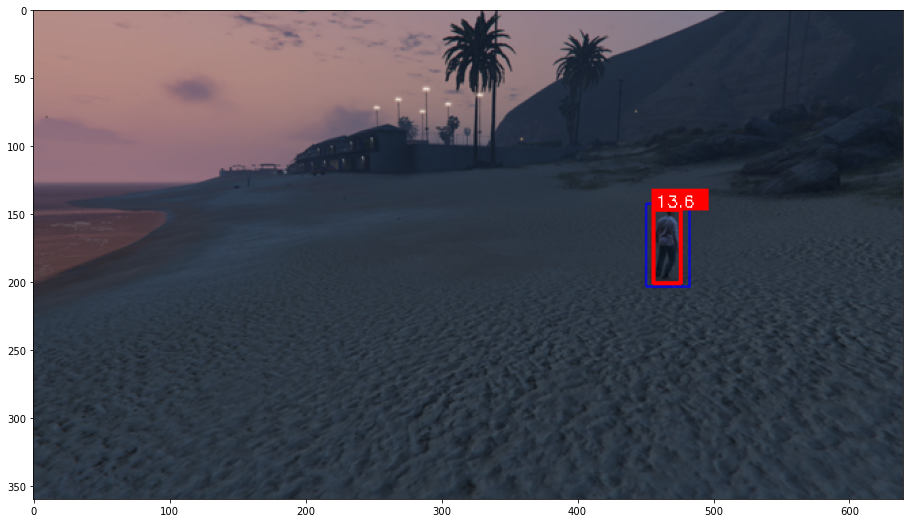

In [89]:
boxes = np.column_stack((person_box, y_pred))

for box in boxes:   
    cv2.rectangle(box_img, (round(box[0]),round(box[1])), (round(box[2]),round(box[3])), (255, 0, 0), 2)
    cv2.rectangle(box_img, (round(box[0]) - 1, round(box[1]) - 15), (round(box[0]) + 40, round(box[1])), (255, 0, 0), -1)
    cv2.putText(box_img, str(round(box[4], 2)), (round(box[0]) + 2, round(box[1]) - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

%matplotlib inline
plt.figure(figsize=(16,9))
plt.imshow(box_img)